In [1]:
import requests
import requests.auth
import datetime as dt
import time


import pandas as pd

# api wrapper
from psaw import PushshiftAPI
api = PushshiftAPI()

import json
import pprint
pp = pprint.PrettyPrinter(indent=4)

#natural language processing libraries
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
from nltk.probability import FreqDist
nltk.download('brown')
nltk.download('conll2000')

#textblob imports
from textblob import Blobber
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import FastNPExtractor
tb = Blobber(analyzer=NaiveBayesAnalyzer())

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/shujinkou/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shujinkou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /Users/shujinkou/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/shujinkou/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


# Pushshift API wrapper query
    * automatic rate limiting
    * faster queries as it doesn't actually directly query reddit's servers
    * better searching

### Pushshift submission API request

In [3]:
# get all threads from the bitcoinmarket subreddit, gen is a generator 

start_epoch=int(dt.datetime(2013, 1, 1).timestamp())
gen = api.search_submissions(after=start_epoch,
        subreddit='bitcoinmarkets', #specify the subforum
        sort = 'asc',
            # filter=['url','author', 'title', 'subreddit'], # choose which dictionary keys to display
        limit=100000)

In [4]:
# iterate through the generator to create a submission array
# x.d_ is a method that converts each submission object to a dictionary
results = list(map(lambda x: x.d_, gen))

In [5]:
df = pd.DataFrame(results)
df.to_csv('bitcionmarkets_threads.csv')
df.to_json('')

### Pushshift comment API request

In [13]:
# searching for comments in the bitcoinmarkets subredidt

def query_comments(search, max_response_cache):
    """ Finds comments within a particular subreddit containing a phrase
    
    Keyword arguments:
    search (string) -- phrase to search for
    max_response_cache(int) -- maximum number of comments to retreive

    """
    gen = api.search_comments(q=search, subreddit='bitcoinmarkets')
    cache = []

    for c in gen:
        cache.append(c.d_)

        # Omit this test to actually return all results
        if len(cache) >= max_response_cache:
            break
            
    return cache

In [3]:
bullish = query_comments("bullish", 100000)
bearish = query_comments("bearish", 100000)
print(len(bullish))
print(len(bearish))

25400
15797


### Natural Language Processing. Sentiment and noun phrase extraction

In [2]:
def get_sentiment(comment):
    """ Returns texblob sentiment analysis for a comment's body
    
    Keyword arguments:
    comment (dict) -- element from a query_comments array
    """
    return TextBlob(comment['body']).sentiment

In [13]:
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool()
# utalize all cores
# applies sentiment analysis to each comment
bullish_sentiments = pool.map(lambda x: tb(x['body']).sentiment, bullish)
#close the pool and wait for the work to finish
pool.close()
pool.join()

In [14]:
bullish_polarity = list(map(lambda x: x.p_pos, bullish_sentiments))

In [69]:
import numpy as np
# rargmin eturns comment with the lowest polarity
print(bullish[np.argmin(bullish_polarity)]['body'])

I'm insanely bullish about the price in the medium term and I'd love to leverage those gains up. But im a bit thick and even if I wasnt I dont think low leverage is a good idea at the moment. 60/40 seems crazy irresponsible. But I can get a lot of Yolos for that price even with randomly selected my way in I feel like I'm much more likely to come right. One random shot every week for the next few months at say 50 times seems very likely to come right at least once, and maybe right a lot of times. Of course the price actually needs to rise, but if it drops for months low leverage is dead anyway. I'm making excuses for greed, but I wonder if there is not a way to make this about as safe as holding alone. Say 10 percent fiat ashedge/rebut at the bottom. And a random leveraged punt every week for a year. So much

Upside, and the odds seem good? I'm a bit clueless though. Can still get stopped out I guess. What are the odds of Getting unlucky is the price is rising at a good rate? If I was d

In [67]:
dt.datetime.fromtimestamp(bearish[-1]['created_utc']).strftime("%m/%d/%Y, %H:%M:%S")

'04/21/2013, 12:01:00'

### example noun phrase extraction
* This can be used for a bubble word frequency chart, or a cooccurance graph

In [3]:
def noun_cooccurance(query, num_comments=1000):
    """ returns most freuqent words used within the same comments matching a search query
    
    Arguments:
    query (string) -- search within comments containing this phrase
    num_comments -- how many comments to include in coocurance. Searches from present back
    """
    results = query_comments(query , num_comments)
    # concatinate all the text in each comment into a single string to apply textblob
    results_join = ' '.join(list(map(lambda x: x['body'], results)))
    
    # there are two models for extracting noun phrases, Conll is faster, but less accurate
    from textblob.np_extractors import ConllExtractor
    #extractor = FastNPExtractor()
    extractor = ConllExtractor()

    # tb_noun is a "blobber" convience function that converts strings into textblob objects
    tb_noun = Blobber(np_extractor=extractor)
    df = pd.DataFrame(FreqDist(tb_noun(results_join).noun_phrases).most_common(50)) # pick 50 most common words
    df = df.rename(columns = {0: "word", 1: "frequency"})
    
    # df.to_json('./bubble_chart/data/word_frequency.json', orient="records")
    
    results_json = df.to_json(orient="records")
    data = json.loads(results_json)
    punctuation = ["/'", "’", "’", " "] # noun phrase extractor leaves in contractions as 
    # unique words, the list comprehension removes these entries
    clean_results = [x for x in data if x['word'][1] not in punctuation]
    with open('./bubble_chart/data/word_frequency.json', 'w') as fout:
        json.dump(clean_results, fout)
        
    return clean_results
        
    

In [4]:
def comment_date_agg(query, days=3000, subreddit="bitcoinmarkets"):
    """ returns count of comments with query string within a subreddit aggregated 
        by days
        
        Keyword Arguments:
        query (string) -- word or phrase to search for
        days (int/string) -- how many back to get data for, this is the number of entries returned
        subreddit (string) -- which subreddit to search (default="bitcoinmarkets")
    """
    url = "https://api.pushshift.io/reddit/search/comment/"
    payload = {"q" : query, "after" : f'{days}d',
               "subreddit" : subreddit,
               "aggs" : "created_utc",
               "frequency" : "days",
               "size" : 0}
    results = requests.get(url, params=payload).json()
    return results

2017-12-21 19:00:00


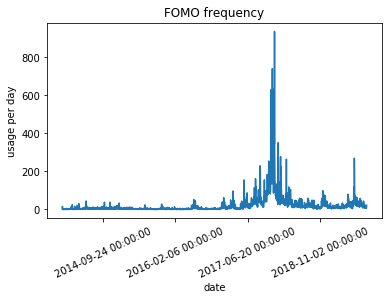

In [10]:
results = comment_date_agg("HODL", subreddit="bitcoin")
timestamps = [x['key'] for x in results['aggs']['created_utc']]
values = [x['doc_count'] for x in results['aggs']['created_utc']]


import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import datetime as dt
import time



dates=[dt.datetime.fromtimestamp(ts) for ts in timestamps]
datenums=md.date2num(dates)
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.title("FOMO frequency")
plt.xlabel("date")
plt.ylabel("usage per day")
plt.plot(datenums,values)
print(dates[np.argmax(values)])

In [29]:
len(results['aggs']['created_utc'])

2344

In [18]:
noun_cooccurance("bullish", 1000)

[{'word': 'bitcoin', 'frequency': 107},
 {'word': 'bull market', 'frequency': 23},
 {'word': 'bullish divergence', 'frequency': 23},
 {'word': 'price action', 'frequency': 23},
 {'word': 'june', 'frequency': 17},
 {'word': 'long term', 'frequency': 15},
 {'word': 'long term bullish', 'frequency': 14},
 {'word': 'short term', 'frequency': 14},
 {'word': 'bullish continuation', 'frequency': 14},
 {'word': 'last time', 'frequency': 13},
 {'word': 'pa', 'frequency': 13},
 {'word': 'ta', 'frequency': 12},
 {'word': 'bullish trend', 'frequency': 12},
 {'word': 'new ath', 'frequency': 11},
 {'word': 'hidden bullish divergence', 'frequency': 11},
 {'word': 'bearish divergence', 'frequency': 11},
 {'word': 'april', 'frequency': 11},
 {'word': 'bullish af', 'frequency': 11},
 {'word': 'bitcoin dominance', 'frequency': 11},
 {'word': 'bakkt', 'frequency': 10},
 {'word': 'same thing', 'frequency': 10},
 {'word': 'price', 'frequency': 10},
 {'word': 'bitmex', 'frequency': 9},
 {'word': 'good luck',